In [4]:
# CPU 런타임 환경 설정
!pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.6 MB 656.4 kB/s eta 0:00:59
   -- ------------------------------------- 2.8/38.6 MB 19.6 MB/s eta 0:00:02
   ------- -------------------------------- 7.5/38.6 MB 43.6 MB/s eta 0:00:01
   ------------- -------------------------- 12.7/38.6 MB 108.8 MB/s eta 0:00:01
   ---------------- ----------------------- 15.9/38.6 MB 81.8 MB/s eta 0:00:01
   --------------------- ------------------ 21.1/38.6 MB 93.0 MB/s eta 0:00:01
   -------------------------- ------------- 25.8/38.6 MB 93.9 MB/s eta 0:00:01
   ------------------------------- -------- 30.5/38.6 MB 108.8 MB/s eta 0:00:01
   ------------------------------------ --- 34.9/38.6 MB 93.9 MB/s eta 0:00:01
   ---------------------------------------  38.6/38.6 MB 93.9 MB/s eta 0:00:01
   ---------------------------------------  38.6/38.6 MB 93.9 MB/s eta

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.15.0


[]

In [2]:
# 보안 문제로 ipynb 파일 open시마다 실행
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:
    # rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/ai/cnn/green' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (5, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

# ---------------------------------------------------------------------

ModuleNotFoundError: No module named 'cv2'

In [5]:
# 주어진 폴더의 모든 파일을 numpy array로 변환하는 함수
def convertArray(path, width, height):
    file_list = os.listdir(path)
    img_X = [] # data
    img_Y = [] # target

    for i in range(len(file_list)): # 파일을 하나씩 읽음
        spt = os.path.splitext(file_list[i])
        # print(spt) # ('0', '.jpg')
        img_Y.append(int(spt[0])) # 파일명

#         img = Image.open(path + "/" + file_list[i])
#         img_array = np.array(img)
        image_bgr = cv2.imread(path + "/" + file_list[i], cv2.IMREAD_COLOR)
        image_bgr  = cv2.resize(image_bgr, (width, height))
        image_rgb = cv2.cvtColor(image_bgr , cv2.COLOR_BGR2RGB)

        # 1차원 list안에 color 3차원 배열로 변경된 이미지를 저장
        img_X.append(image_rgb)

    img_X = np.array(img_X) # 이미지 데이터 [] -> ndarray
    img_Y = np.array(img_Y) # Target, Y


    # OpenCV는 흰색을 255로 나타냄으로 변환이 필요함.
    img_X = 255 - img_X # 색이 없으면 0으로 인식되게 변환, 255 - 4차원 배열

    # 텐서플로와 GPU 실수 기반에 최적화되어 있어
    # 0 ~ 1 사이의 실수 값으로 변경하면 정확도 상승, 정규화
    img_X = img_X / 255.0
    print(f'{path} 폴더의 이미지: ', img_X.shape);

    # img_Y.reshape(img_Y.shape[0], 1): target은 2차원 배열의 형태이어야함.
    # 행수는 이미지 수, 컬럼이 1개인 2차원 배열
    # astype(int): 찾아야하는 값은 정수이기 때문에 형변환
    return img_X, img_Y.reshape(img_Y.shape[0], 1).astype(int)

In [6]:
# 데이터 준비
width = 64
height = 64

x_train, y_train = convertArray('./train', width, height) # 훈련용
x_test, y_test = convertArray('./test', width, height)    # 테스트용
# (90, 64, 64, 3): 칼라 이미지 72장, (count, height, width, color channel)

./train 폴더의 이미지:  (90, 64, 64, 3)
./test 폴더의 이미지:  (5, 64, 64, 3)


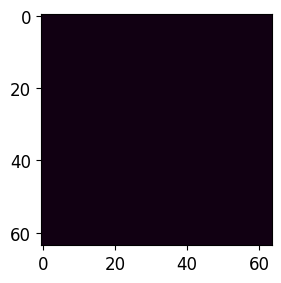

In [7]:
# 테스트할 첫번째 이미지 확인, 정규화하여 색상이 변경됨.
plt.imshow(x_train[0]);
plt.show()

In [8]:
print(x_train.shape) # 훈련 데이터
print(y_train.shape) # (70, 1), 녹초 수치, 정수형

# print(x_val.shape)   # 검증데이터
# print(y_val.shape)

print(x_test.shape)  # 테스트데이터
print(y_test.shape)
print(y_test)

(90, 64, 64, 3)
(90, 1)
(5, 64, 64, 3)
(5, 1)
[[200]
 [150]
 [100]
 [ 13]
 [ 50]]


In [9]:
print(type(x_train[0, 0, 0, 0])) # 첫번째 이미지 첫번째 픽셀의 type 확인
print(x_train[0:1]) # 첫번째 이미지 배열 값

<class 'numpy.float64'>
[[[[0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   ...
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]]

  [[0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   ...
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]]

  [[0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   ...
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]]

  ...

  [[0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   ...
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]
   [0.06666667 0.         0.07058824]]

  [[0.06666667 0.    

In [10]:
print(y_train[0:10]) # 훈련 target 확인

[[17]
 [20]
 [21]
 [22]
 [25]
 [23]
 [30]
 [29]
 [35]
 [32]]


In [11]:
 # (None, 128, 128, 128)     3584: 128 x 128 이미지, 128 channel
# 3584: 필터_size * 필터 갯수 * color 수 + Bias 수
print(9 * 128 * 3 + 128)

3584


In [12]:
# 네트워크 구성
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# 128: 128 개의 2차원 특징맵이 생성됨, 필터(커널)의 수.
# kernel_size = (3, 3): 필터 크기는 3행 3열의 난수기반 행렬이 생성됨.
# padding='same': 차원 축소를 방지, 외곽에 0을 추가
# input_shape = (width, height, 3): 칼라 입력 이미지, 흑백: 1
# model.add(Conv2D(64, kernel_size = (3, 3), padding='same',
#                  input_shape = (width, height, 3), activation='relu'))

model.add(Conv2D(128, kernel_size = (3, 3), padding='same',
                 input_shape = (height, width, 3), activation='relu'))
# (None, 128, 128, 128)     3584: 128 x 128 이미지, 128 channel
# 3584: 필터_size * 필터 갯수 * color 수 + Bias 수
#       9 * 128 * 3 + 128

# 특성맵이 128 -> 32개로 감소
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

# 4개중에 최대값 1개만 다음 레이어로 전달, 특징만 추출
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음, 파라미터 감소.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(1)) # 활성화 함수 생략시 수치 예측(회귀 산출)
model.compile(optimizer='adam', loss='mse')

model.summary()

# mcp = ModelCheckpoint(filepath='./Green.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start = time.time()
hist = model.fit(x_train, y_train,
                 validation_split=0.2,
                 shuffle=True,
                 epochs=1000,
                 batch_size=1,
                 callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# patience=5, Total params: 309,601
# i5 2320: 130s, i5 8500 6core: 90s, i9-10900kf: i9-11900H 42s,
# Ryzen 7 2700X: , Ryzen 5 5600u: 35s, Ryzen 5 3600: 29s
# RTX 3090: 4.68s, RTX 2080: 5.57s, GTX 1060: 18s, Colab GPU: 20~33s
# loss: 10898.1055 - val_loss: 214.2879
# loss: 10898.1055 - val_loss: 214.2879
# loss: 10898.1055 - val_loss: 214.2879 23.36s


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                   

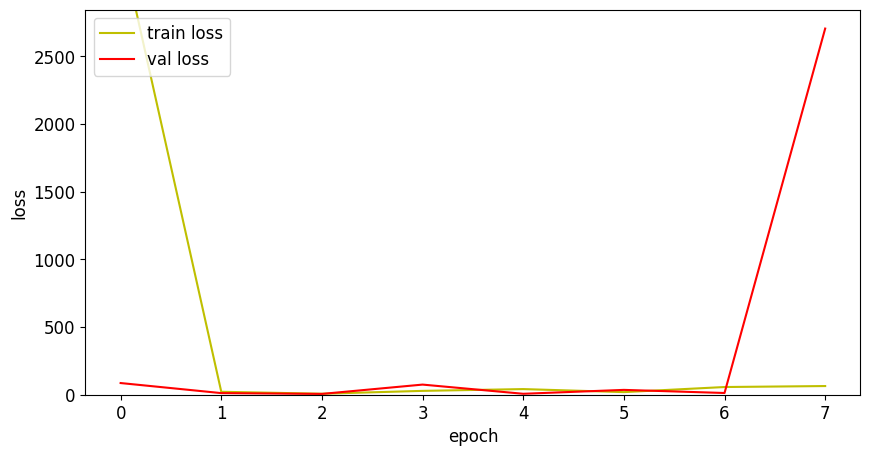

In [13]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 2844.6963]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
# acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
# acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
# acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
# acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [14]:
loss = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', loss)

손실값: 0.8207237124443054


In [15]:
yp = model.predict(x_test, batch_size=1) # 모델 사용
print(yp)

5/5 [==============================] - 0s 8ms/step
[[198.8352  ]
 [150.3716  ]
 [ 98.849365]
 [ 12.300562]
 [ 50.89197 ]]


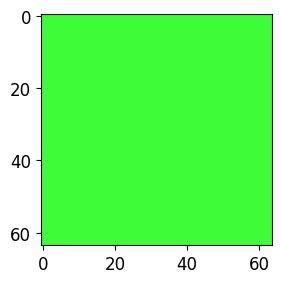

In [16]:
# 테스트할 첫번째 이미지 확인
file_list = os.listdir('./test')
img_bgr = cv2.imread('./test' + "/" + file_list[0], cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);

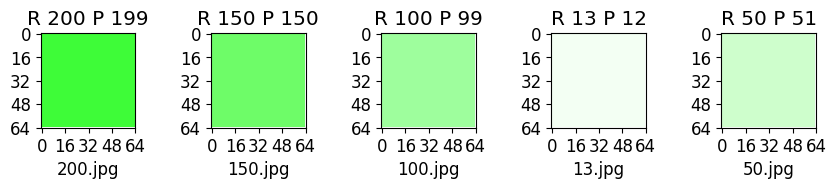

In [17]:
import glob # 파일 필터링

# fig.set_size_inches(16, 5)  # 챠트 크기 설정
plt.rcParams["figure.figsize"] = (10, 4) # subplot 크기 결정
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
fig.tight_layout() # 최적의 간격 설정
rows = 1           # 1행 4열 이미지 출력
cols = 5
i = 1

# left - 왼쪽 margin. 디폴트는 0.125
# right - 오른쪽 margin. 디폴트는 0.9
# bottom - 아래쪽 margin. 디폴트는 0.1
# top - 위쪽 margin. 디폴트는 0.9
# wspace - subplots 의 수평 간격. 디폴트는 0.2
# hspace - subplots 의 수직 간격. 디폴트는 0.2
plt.subplots_adjust(wspace=0.8, hspace=0.4)

# 디렉터리 위치 변경
os.chdir('./test')

for filename in glob.glob("*.jpg"): # jpg 파일만 추출
    img_bgr = cv2.imread(filename, cv2.IMREAD_COLOR)
    ax = fig.add_subplot(rows, cols, i) # 1, 5, 1
    ax.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # BGR -> RGB
    # R: 실제값, P: 예측한 값, yp: 예측값, 배열 index: i-1
    ax.set_title('R {0:.0f} P {1:.0f}'.format(y_test[i-1][0], yp[i-1][0]))
    ax.set_xlabel(filename)
    ax.set_xticks([0, 16, 32, 48, 64]) # x축 눈금선
    ax.set_yticks([0, 16, 32, 48, 64])
    i += 1 # 서브플롯 갯수 증가

plt.show()
os.chdir("..") # 기본 경로로 변경